In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define hyperparameters
num_epochs = 50
batch_size = 100
learning_rate = 0.001

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations #with data augmentation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform_augment = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Downloading the datasets
# full_train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
# Apply the data augmentation transformations to the training dataset
full_train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform_augment)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)  # No augmentation on test data

# Creating a validation split
train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])

# Creating the data loaders with the appropriate batch size and number of workers
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Data batch shape: torch.Size([100, 1, 28, 28])


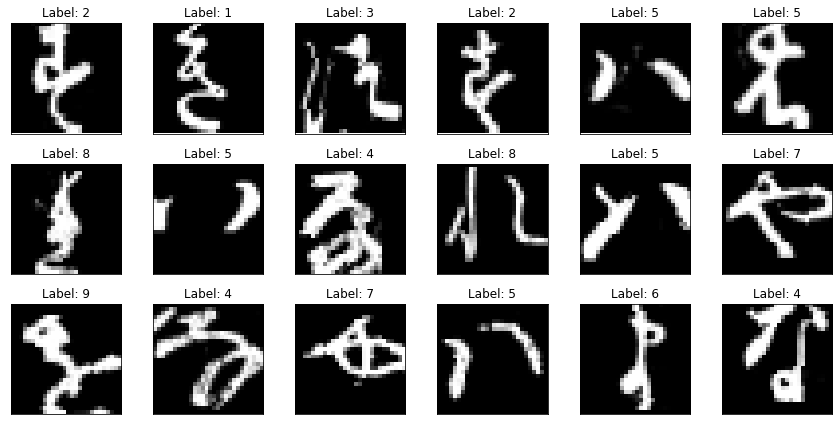

In [3]:
import matplotlib.pyplot as plt

# Load one batch of images along with their labels
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Fetch a batch of images and corresponding labels

# Determine the number of images to display (up to 18), and adjust if fewer images are in the batch
num_images = min(18, len(images))

# Print the shape of the data batch - useful for debugging
print(f'Data batch shape: {images.shape}')

# Create figure for plotting
fig = plt.figure(figsize=(12, 6))  # Wider figure size to accommodate subplots

# Plot the images from the batch
for index in range(num_images):
    ax = fig.add_subplot(3, 6, index + 1, xticks=[], yticks=[])  # Prepare subplot; turn off axis
    # Convert the PyTorch tensor to a NumPy array 
    # Squeeze() is used to remove any singleton dimensions
    npimg = images[index].squeeze().numpy()
    # npimg = np.transpose(npimg, (1, 2, 0))  # If the image is not grayscale
    npimg = npimg * 0.5 + 0.5  # Un-normalize the image
    ax.imshow(npimg, cmap='gray')  
    # Display the corresponding label below each image
    ax.set_title(f'Label: {labels[index]}')

# Show the figure holding the subplots
plt.tight_layout()
plt.show()


# Check data split

In [4]:
# Check the length of the datasets
print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create a validation set from the full training dataset
train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])  # Splitting the training dataset

# Check the sizes of the split datasets
print(f"After split - Training dataset size: {len(train_dataset)}")
print(f"After split - Validation dataset size: {len(val_dataset)}")

Full training dataset size: 60000
Test dataset size: 10000
After split - Training dataset size: 50000
After split - Validation dataset size: 10000


In [5]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# MLP Model

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.sequence = nn.Sequential(
            nn.Linear(28 * 28, 1024),  # More neurons in the first layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Less dropout
            nn.Linear(1024, 512),  # More neurons in the second layer
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Batch normalization
            nn.Dropout(0.2),  # Consistent dropout
            nn.Linear(512, 256),  # Traditional halving of units
            nn.ReLU(),
            # No dropout here, let's see if it helps!
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Adding dropout before the final layer might help generalize better
            nn.Linear(128, 10)  # Final layer remains the same
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.sequence(x)
        return x


# Model Criterion and optimizer

In [7]:
# Initialize the model, criterion, and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Training function

In [8]:
# Function for training or evaluation
from collections import defaultdict
def run_epoch(loader, model, criterion, optimizer=None, device=None):
    """
    Utility function for training/validation per epoch.
    """
    # Check if in training mode
    is_training = optimizer is not None
    
    # Store performance data
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Set model mode
    if is_training:
        model.train()
    else:
        model.eval()

    for batch in loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU, if available

        # Reset gradients
        if is_training:
            optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization
        if is_training:
            loss.backward()
            optimizer.step()

        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(loader)
    accuracy = (correct_predictions / total_predictions) * 100.0

    return avg_loss, accuracy

# Training and Validation Set

In [9]:
from copy import deepcopy

performance_tracking = defaultdict(list)

# Initialize early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5  # Number of epochs to wait for improvement before stopping
early_stop = False  # Flag to indicate early stopping

# We will also store the best model parameters corresponding to the best validation loss
best_model_params = deepcopy(model.state_dict())

for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy = run_epoch(train_loader, model, criterion, optimizer, device=device)
    
    # Validation
    val_loss, val_accuracy = run_epoch(val_loader, model, criterion, device=device)  # No optimizer passed in validation

    # Store performance data
    performance_tracking['train_loss'].append(train_loss)
    performance_tracking['train_accuracy'].append(train_accuracy)
    performance_tracking['val_loss'].append(val_loss)
    performance_tracking['val_accuracy'].append(val_accuracy)

    # Print statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_params = deepcopy(model.state_dict())  # save the better model parameters
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            early_stop = True
            model.load_state_dict(best_model_params)  # restore best model
            break  # break the training loop

    print('---------------------------------------')

# If early stopping did not occur, load the best model parameters found during training
if not early_stop:
    model.load_state_dict(best_model_params)


Epoch 1/50
Train Loss: 0.8729, Train Accuracy: 71.06%
Validation Loss: 0.5680, Validation Accuracy: 81.49%
---------------------------------------
Epoch 2/50
Train Loss: 0.5413, Train Accuracy: 82.56%
Validation Loss: 0.3993, Validation Accuracy: 87.27%
---------------------------------------
Epoch 3/50
Train Loss: 0.4510, Train Accuracy: 85.57%
Validation Loss: 0.3401, Validation Accuracy: 89.28%
---------------------------------------
Epoch 4/50
Train Loss: 0.4007, Train Accuracy: 87.16%
Validation Loss: 0.3086, Validation Accuracy: 90.35%
---------------------------------------
Epoch 5/50
Train Loss: 0.3541, Train Accuracy: 88.82%
Validation Loss: 0.2547, Validation Accuracy: 91.81%
---------------------------------------
Epoch 6/50
Train Loss: 0.3296, Train Accuracy: 89.61%
Validation Loss: 0.2675, Validation Accuracy: 91.81%
---------------------------------------
Epoch 7/50
Train Loss: 0.3186, Train Accuracy: 89.90%
Validation Loss: 0.2547, Validation Accuracy: 91.87%
-----------

# test evaluation

In [10]:
# Switch model to evaluation mode
model.eval()  # Important to ensure that layers like dropout behave consistently during inference

# Collect the true and predicted labels
test_true_labels = []
test_pred_labels = []

with torch.no_grad():  # No need to track the gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Save the true and predicted labels for further metrics analysis
        test_true_labels.extend(labels.cpu().numpy())
        test_pred_labels.extend(predictions.cpu().numpy())


# confusion matrix

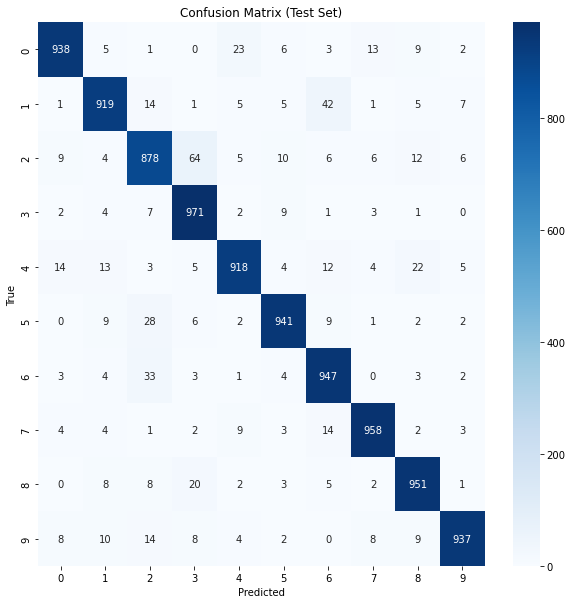

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Using sklearn to create the confusion matrix
cm_test = confusion_matrix(test_true_labels, test_pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


In [13]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(test_true_labels, test_pred_labels, target_names=[f'Class {i}' for i in range(10)])  # or your actual class names

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95      1000
     Class 1       0.94      0.92      0.93      1000
     Class 2       0.89      0.88      0.88      1000
     Class 3       0.90      0.97      0.93      1000
     Class 4       0.95      0.92      0.93      1000
     Class 5       0.95      0.94      0.95      1000
     Class 6       0.91      0.95      0.93      1000
     Class 7       0.96      0.96      0.96      1000
     Class 8       0.94      0.95      0.94      1000
     Class 9       0.97      0.94      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



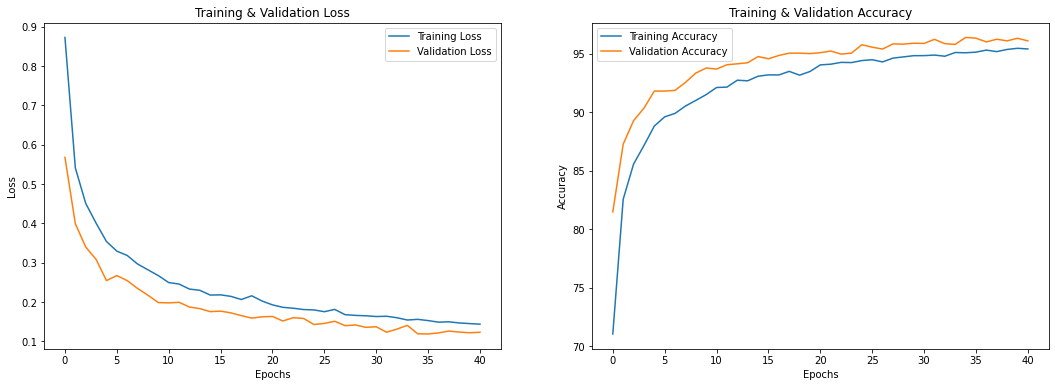

In [14]:
# Importing required libraries for plotting
import matplotlib.pyplot as plt

# Extracting values from the performance tracking
train_loss = performance_tracking['train_loss']
val_loss = performance_tracking['val_loss']
train_accuracy = performance_tracking['train_accuracy']
val_accuracy = performance_tracking['val_accuracy']

# Creating subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()

# Plotting training and validation accuracy
ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()

# Show plots
plt.show()
